In [1]:
### Loading required modules

import numpy as np
import tensorflow as tf
import os,sys
import datetime
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, save_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Activation, Dense
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import cv2
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

tf.config.list_physical_devices('GPU')

path="/home/ubuntu/pediatric_dental_age_prediction/mask/"

print("Loaded all modules")

2023-11-14 12:42:24.934969: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 12:42:25.598208: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loaded all modules


2023-11-14 12:42:27.168176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 12:42:27.191378: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 12:42:27.193548: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
### Prep for training data (11 GB RAM used for 1400 images + 1400 masks)

X_train_li = [] ### arrays of augmented images
Y_train_li = [] ### arrays of augmented true masks

subj_train_li = []
fn_train_li = []

for imgFn in os.listdir(path+"train_image_aug"):
    cvImgNorm = cv2.imread(path+"train_image_aug/"+imgFn)/255
    _, cvTrueMaskNorm = cv2.threshold(cv2.imread(path+"train_trueMask_aug/"+imgFn),
                             128, 256, cv2.THRESH_BINARY)
    cvTrueMaskNorm = tf.cast(tf.image.rgb_to_grayscale(cvTrueMaskNorm)/255, dtype=tf.uint8)

    subj = "_".join(imgFn.split("_")[:2])
    
    
    X_train_li.append(cvImgNorm)
    Y_train_li.append(cvTrueMaskNorm)
    subj_train_li.append(subj)
    fn_train_li.append(imgFn)

X_train = np.array(X_train_li)
Y_train = np.array(Y_train_li)
print("Prep for train set done")

2023-11-14 12:42:32.223618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 12:42:32.225777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 12:42:32.227656: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Prep for train set done


In [3]:
### Prep for testing data (2 GB RAM used for 300 images + 300 masks)

X_test_li = [] ### arrays of augmented images
Y_test_li = [] ### arrays of augmented true masks

subj_test_li = []
fn_test_li = []

for imgFn in os.listdir(path+"test_image_aug"):
    cvImgNorm = cv2.imread(path+"test_image_aug/"+imgFn)/255
    _, cvTrueMaskNorm = cv2.threshold(cv2.imread(path+"test_trueMask_aug/"+imgFn),
                             128, 256, cv2.THRESH_BINARY)
    cvTrueMaskNorm = tf.cast(tf.image.rgb_to_grayscale(cvTrueMaskNorm)/255, dtype=tf.uint8)
    subj = "_".join(imgFn.split("_")[:2])
    
    
    X_test_li.append(cvImgNorm)
    Y_test_li.append(cvTrueMaskNorm)
    subj_test_li.append(subj)
    fn_test_li.append(imgFn)

X_test = np.array(X_test_li)
Y_test = np.array(Y_test_li)
print("Prep for test set done")

Prep for test set done


In [4]:
### Defining U-Net

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Activation, Dense
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

def double_conv_block(x, n_filters):
    # (Conv2D + ReLU) twice
    for i in range(2):
        x = Conv2D(filters = n_filters, kernel_size = (3, 3), 
                   padding = "same", activation = "relu", 
                   kernel_initializer = "he_normal")(x)
    return x
    
def encoder_block(x, n_filters, dropoutRateGiven):
    # double conv block added, then performing down-sampling of the output
    
    f = double_conv_block(x, n_filters)
    p = MaxPooling2D(pool_size=(2, 2))(f)
    p = Dropout(dropoutRateGiven)(p)
    return f, p

def encoder(x, dropoutRateGiven):
    # Encoder architecture (downsampling)
    
    f1, p1 = encoder_block(x, n_filters = 64, dropoutRateGiven = dropoutRateGiven)
    f2, p2 = encoder_block(p1, n_filters = 128, dropoutRateGiven = dropoutRateGiven)
    f3, p3 = encoder_block(p2, n_filters = 256, dropoutRateGiven = dropoutRateGiven)
    f4, p4 = encoder_block(p3, n_filters = 512, dropoutRateGiven = dropoutRateGiven)
    return p4, (f1,f2,f3,f4)

def bottleneck(x):
    # Bottleneck architecture
    b = double_conv_block(x, n_filters = 1024)
    return b

def decoder_block(x, conv_x, n_filters, dropoutRateGiven):
    # Decoder architecture (upsampling with Conv2DTranspose + encoder conv output concatenated)
    u = Conv2DTranspose(n_filters, kernel_size=(3,3), strides=(2,2),
                       padding="same")(x)
    c = tf.keras.layers.concatenate([u,conv_x])
    c = Dropout(dropoutRateGiven)(c)
    c = double_conv_block(c, n_filters)

    return c

def decoder(x, conv_tuple, dropoutRateGiven):

    f1, f2, f3, f4 = conv_tuple

    c6 = decoder_block(x, f4, n_filters = 512, dropoutRateGiven = dropoutRateGiven)
    c7 = decoder_block(c6, f3, n_filters = 256, dropoutRateGiven = dropoutRateGiven)
    c8 = decoder_block(c7, f2, n_filters = 128, dropoutRateGiven = dropoutRateGiven)
    c9 = decoder_block(c8, f1, n_filters = 64, dropoutRateGiven = dropoutRateGiven)
    
    ## Sigmoid activation for binary classification (Background or Foreground)
    outputs = Conv2D(1, 1, padding = "same", activation = "sigmoid")(c9)
    
    return outputs

def createUNet(inputShape, dropoutRateGiven = 0.3):
    x = tf.keras.layers.Input(shape=inputShape)

    encoder_res, conv_tuple = encoder(x, dropoutRateGiven = dropoutRateGiven)
    bottleneck_res = bottleneck(encoder_res)
    outputs = decoder(bottleneck_res, conv_tuple, dropoutRateGiven = dropoutRateGiven)

    model = tf.keras.Model(x, outputs)

    return model
    
    
print("U-Net built with tensorflow.keras")

U-Net built with tensorflow.keras


In [5]:
### U-Net parameters

## Learning part

lossFunction = "binary_crossentropy" # Binary classification

learningRate = 1e-4
epochSize = 20
batchSize = 8

optimizer = "Adam"

def optimizer_select(optimizer, 
                     learningRate):
    
    if optimizer == "Adam":
        opt = Adam(learning_rate=learningRate)
    elif optimizer == "RMSprop":
        opt = RMSprop(learning_rate=learningRate)
    elif optimizer == "SGD":
        opt = SGD(learning_rate=learningRate)
    
    return(opt)


model = createUNet(inputShape = X_train.shape[1:])

model.compile(loss=lossFunction, 
              optimizer = optimizer_select(optimizer, learningRate),
              metrics=['acc'])

print("U-Net successfully compiled")

U-Net successfully compiled


In [6]:
### Training the U-Net model

print("Training the U-Net model...")

modelHistory = model.fit(x=X_train, y=Y_train,
                    validation_data = (X_test, Y_test),
    epochs=epochSize, batch_size=batchSize, verbose = 1)


Training the model...
Epoch 1/20


2023-11-12 17:33:40.329517: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-12 17:33:40.813061: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903
2023-11-12 17:33:42.731461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-12 17:33:42.746754: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f23938064d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-12 17:33:42.746777: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2023-11-12 17:33:42.750877: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabli

175/175 [==============================] - 74s 333ms/step - loss: 0.3013 - acc: 0.8662 - val_loss: 0.3786 - val_acc: 0.8146
Epoch 2/20
175/175 [==============================] - 56s 321ms/step - loss: 0.1769 - acc: 0.9235 - val_loss: 0.2025 - val_acc: 0.9256
Epoch 3/20
175/175 [==============================] - 56s 321ms/step - loss: 0.1433 - acc: 0.9385 - val_loss: 0.1455 - val_acc: 0.9373
Epoch 4/20
175/175 [==============================] - 56s 320ms/step - loss: 0.1159 - acc: 0.9500 - val_loss: 0.1338 - val_acc: 0.9433
Epoch 5/20
175/175 [==============================] - 56s 320ms/step - loss: 0.0931 - acc: 0.9596 - val_loss: 0.0932 - val_acc: 0.9612
Epoch 6/20
175/175 [==============================] - 56s 320ms/step - loss: 0.0812 - acc: 0.9648 - val_loss: 0.0905 - val_acc: 0.9627
Epoch 7/20
175/175 [==============================] - 56s 319ms/step - loss: 0.0721 - acc: 0.9686 - val_loss: 0.0792 - val_acc: 0.9671
Epoch 8/20
175/175 [==============================] - 56s 320ms/st

In [7]:
### Saving the model

import datetime
import pickle

lossFxShort = "".join([x[0] for x in lossFunction.split("_")])
modelTime = (datetime.datetime.now() + datetime.timedelta(hours=9)).strftime('%m%d_%H%M')

modelName = path+"model/unet.lr_{0}.optimizer_{1}.epoch_{2}.batch_{3}.\
time_{4}.keras".format(learningRate,optimizer,epochSize,batchSize,modelTime)

model.save(modelName)

print("Model fully trained and saved")

Model fully trained and saved


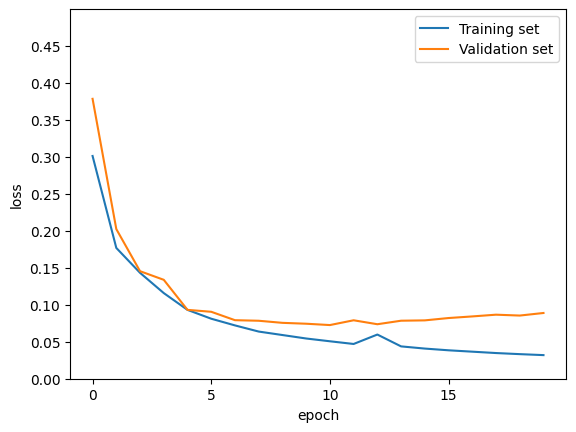

In [11]:
### U-Net learning curve

from matplotlib import pyplot as plt

ylimLoss = 0.5

plt.plot(modelHistory.history['loss'], label = "Training set")
plt.plot(modelHistory.history['val_loss'], label = "Validation set")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.xticks(np.arange(0,epochSize, 5))
plt.yticks(np.arange(0,ylimLoss, 0.05))
plt.ylim(bottom=0, top=ylimLoss)
plt.legend()

plt.show()

In [57]:
### Saving probabilty masks and binarized masks

## Training data
train_predMask = model.predict(X_train)

for num in range(train_predMask.shape[0]):
    predMaskHighDim = train_predMask[num]
    fileName = fn_train_li[num]
    d1,d2,d3 = predMaskHighDim.shape
    predMask = predMaskHighDim.reshape(1,d1,d2,d3)[0,...]
    _, predMask_bin = cv2.threshold(predMask,0.5,1,cv2.THRESH_BINARY)   ## Probability to binary values (0.05, 0.61, 0.97) -> (0, 1, 1)
    predMask_bin = predMask_bin.reshape(d1,d2,d3)
        
    save_img(path+"train_predMask/{0}".format(fileName),
             predMask, file_format="jpeg")
    save_img(path+"train_predMask_bin/{0}".format(fileName),
             predMask_bin, file_format="jpeg")


# Test data
test_predMask = model.predict(X_test)

for num in range(test_predMask.shape[0]):
    predMaskHighDim = test_predMask[num]
    fileName = fn_test_li[num]
    d1,d2,d3 = predMaskHighDim.shape
    predMask = predMaskHighDim.reshape(1,d1,d2,d3)[0,...]
    _, predMask_bin = cv2.threshold(predMask,0.5,1,cv2.THRESH_BINARY)   ## Probability to binary values (0.05, 0.61, 0.97) -> (0, 1, 1)
    predMask_bin = predMask_bin.reshape(d1,d2,d3)
        
    save_img(path+"test_predMask/{0}".format(fileName),
             predMask, file_format="jpeg")
    save_img(path+"test_predMask_bin/{0}".format(fileName),
             predMask_bin, file_format="jpeg")

print("Predicted masked were all saved")

10/10 [==============================] - 4s 484ms/step
Predicted masked were all saved
